In [1]:
import string
import numpy as np
import deepdish as dd
from brian2.only import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.spatial import distance

from SNN import SNN
from sweep import get_script

import plot_utils as pu

In [2]:
rng = np.random.default_rng(14)
n = 8
xy = rng.random((2,n))
xy[:, 0] = 0.5
ord = np.argsort(xy[0])
x, y = xy = xy[:, ord]

J = rng.random((n,n))
D = distance.cdist(xy.T, xy.T)
np.fill_diagonal(J, np.nan)
np.fill_diagonal(D, np.nan)

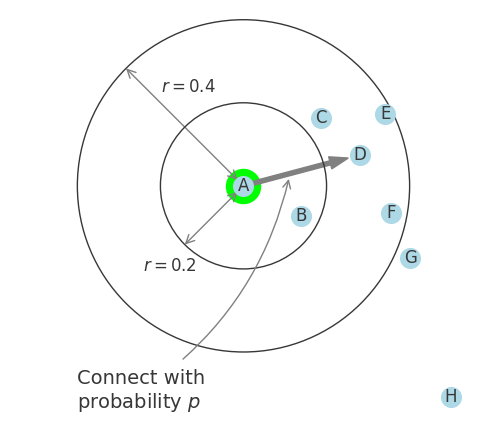

In [3]:
def plot_space(ax, lo, hi):
    # Highlight
    ax.scatter(x[0], y[0], s=150, c='lime', zorder=-2)

    # Circles
    for r in (lo, hi):
        draw_circle = plt.Circle((x[0], y[0]), r, fill=False)
        ax.add_artist(draw_circle)

    # Neurons
    ax.scatter(x, y, s=50, c='lightblue')
    for label, xn, yn in zip(string.ascii_uppercase, x, y):
        ax.text(xn, yn, label, va='center', ha='center', size=6)

    # Annotation
    diagonal = np.sin(np.pi/4)*hi
    dx, dy = -diagonal, diagonal
    ax.annotate('', xy=(x[0], y[0]), xytext=[x[0]+dx, y[0]+dy], arrowprops=dict(arrowstyle='<->, head_length=0.3, head_width=0.15', shrinkA=0, shrinkB=3, color='grey'), zorder=-1)
    ax.annotate(f'$r = {hi}$', xy=[x[0] + dx/2, y[0] + dy/2], xytext=[x[0] + .7*dx, y[0] + .8*dy], size=6)

    diagonal = np.sin(np.pi/4)*lo
    dx, dy = -diagonal, -diagonal
    ax.annotate('', xy=(x[0], y[0]), xytext=[x[0]+dx, y[0]+dy], arrowprops=dict(arrowstyle='<->, head_length=0.3, head_width=0.15', shrinkA=0, shrinkB=3, color='grey'), zorder=-1)
    ax.annotate(f'$r = {lo}$', xy=[x[0] + dx/2, y[0] + dy/2], xytext=[x[0] + 0.8*dx, y[0] + 1.2*dy], size=6, ha='right', va='top')

    # Synapse
    dx, dy = x[3]-x[0], y[3]-y[0]
    ax.arrow(x[0], y[0], 0.9*dx, 0.9*dy, color='grey', length_includes_head=True, width=.01, zorder=-1)
    ax.annotate('Connect with\nprobability $p$', xy=(x[0]+.4*dx, y[0]+.4*dy), xytext=(x[0]-hi, y[0]-1.1*hi), size=7, va='top', ha='left',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2', color='grey'))

    # Format
    sns.despine(ax=ax, bottom=True, left=True)
    ax.set_xticks([])
    ax.set_yticks([])
    for z, set_zlim in [(x, ax.set_xlim), (y, ax.set_ylim)]:
        zlim = min(z[0]-hi, z.min()), max(z[0]+hi, z.max())
        set_zlim(*zlim)
    ax.set_aspect('equal')

    ax.set_ylabel(' \n ')
    for artist in ax.get_children():
        artist.set_clip_on(False)

fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=200, facecolor='w')
plot_space(ax, .2, .4)

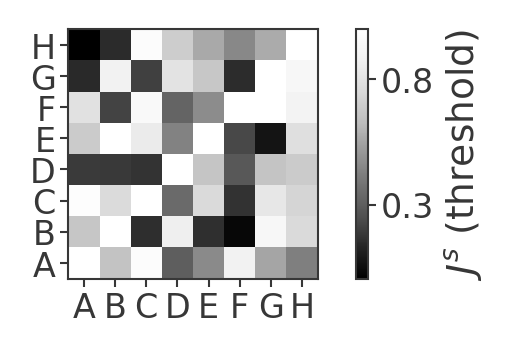

In [4]:
def plot_J(ax, lo, hi):
    m = ax.pcolormesh(J, cmap='Greys_r', vmax=1)
    ax.set_xticks(np.arange(n)+.5, string.ascii_uppercase[:n])
    ax.set_yticks(np.arange(n)+.5, string.ascii_uppercase[:n])
    ax.set_aspect('equal')
    plt.colorbar(m, ax=ax, label='$J^s$ (threshold)', ticks=[lo,hi])

fig, ax = plt.subplots(figsize=(pu.halfwidth(1)), dpi=300)
plot_J(ax, .3, .8)

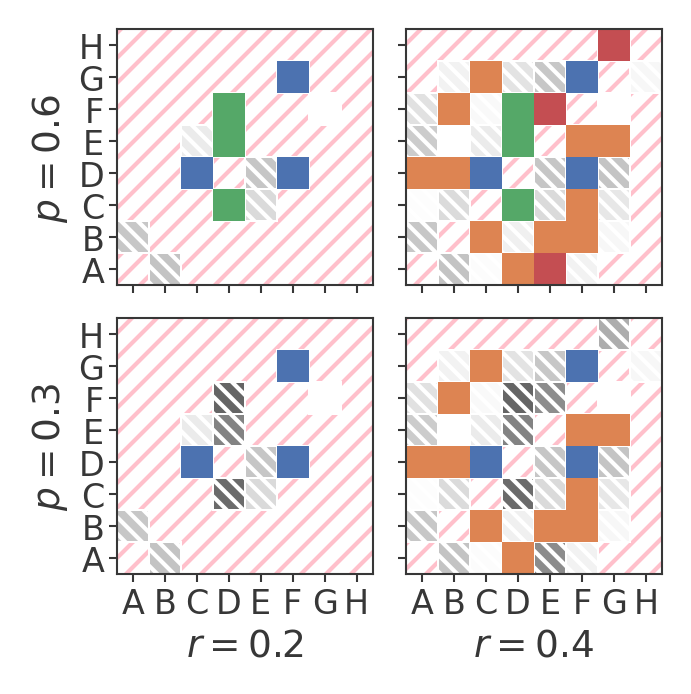

In [5]:
def plot_M(axs, rs, ps):
    cmap = ListedColormap(['#FFFFFF00'] + [f'C{i}' for i in range(4)])

    D0 = (D < rs[0])
    D1 = (D >= rs[0]) & (D < rs[1])
    D2 = (D < rs[1])

    P0 = (J < ps[0])
    P1 = (J >= ps[0]) & (J < ps[1])

    n = len(J)
    for ax in axs.flatten():
        ax.fill_between([0,n], [n,n], fc='none', hatch='////', ec='pink', lw=0)

    M0 = P0 & D0
    axs[1,0].pcolor(np.ma.masked_where(~D0, J), cmap='Greys_r', hatch=r'\\\\\\', ec='w', vmin=0, vmax=1)
    axs[1,0].pcolormesh(M0, cmap=cmap, vmin=0, vmax=4)

    Mr = P0 & D1
    axs[1,1].pcolor(np.ma.masked_where(~D2, J), cmap='Greys_r', hatch=r'\\\\\\', ec='w', vmin=0, vmax=1)
    axs[1,1].pcolormesh(M0 + 2*Mr, cmap=cmap, vmin=0, vmax=4)

    Mp = P1 & D0
    axs[0,0].pcolor(np.ma.masked_where(~D0, J), cmap='Greys_r', hatch=r'\\\\\\', ec='w', vmin=0, vmax=1)
    m = axs[0,0].pcolormesh(M0 + 3*Mp, cmap=cmap, vmin=0, vmax=4)

    Mb = P1 & D1
    axs[0,1].pcolor(np.ma.masked_where(~D2, J), cmap='Greys_r', hatch=r'\\\\\\', ec='w', vmin=0, vmax=1)
    m = axs[0,1].pcolormesh(M0 + 2*Mr + 3*Mp + 4*Mb, cmap=cmap, vmin=0, vmax=4)

    ticks = np.arange(n) + .5
    for ip, (axr, p) in enumerate(zip(axs[::-1], ps)):
        for ir, (ax, r) in enumerate(zip(axr, rs)):
            if ip == 0:
                ax.set_xticks(ticks, string.ascii_uppercase[:n])
                ax.set_xlabel(f'$r = {r}$')
            else:
                ax.set_xticks(ticks, [])
            if ir == 0:
                ax.set_yticks(ticks, string.ascii_uppercase[:n])
                ax.set_ylabel(f'$p = {p}$')
            else:
                ax.set_yticks(ticks, [])
            ax.set_aspect('equal')

fig, axs = plt.subplots(2,2, figsize=pu.halfwidth(2), layout='compressed', dpi=300)
plot_M(axs, (.2,.4), (.3, .6))

In [6]:
def plot_prototype(fig, axs, ax_exc, runseed=0, net=0):
    cmap = ListedColormap(['w', 'C0'])
    for axr, p in zip(axs[::-1], ('01', '03', '05', '07', 1)):
        for ax, r in zip(axr, ('05', 1, 2, 3, 4)):
            script, path = get_script(f'lif_alpha_beta_1_different_net_seed_0_pinh_{p}_rinh_{r}_runseed_{runseed}')

            nonzero = (~np.isnan(dd.io.load(f'{path}/W_final.h5')[net])).astype(int).T  # Transpose to (post, pre)

            ax.pcolormesh(nonzero[:, 80:], cmap=cmap, rasterized=True)
            ax.set_aspect('equal')

            ax.tick_params(which='minor', length=0)
            ax.tick_params(which='minor', axis='x', pad=3)
            ax.set_xticks([0,20], ['',''])
            ax.set_yticks([0,80,100], ['','',''])
            
            p_inh=script.params['p_connection']['IE']
            r_inh=script.params['radius_inh']
            if p == '01':
                ax.set_xlabel(r_inh)
            if r == '05':
                ax.set_ylabel(p_inh)

    axs[-1, 0].set_xticks([19], ['from Inh'], minor=True, ha='right')
    for ax in axs[-1, 1:]:
        ax.set_xticks([10], ['Inh'], minor=True)

    for ax in axs[:-1, 0]:
        ax.set_yticks([40, 90], ['Exc', ' Inh'], minor=True, va='center', rotation='vertical')
    axs[-1, 0].set_yticks([40, 90], ['to Exc', ' Inh'], minor=True, va='center', rotation='vertical')
    
    fig.supxlabel('$r_{inh}$ (mm)')
    fig.supylabel('$p_{inh}$')

    ax_exc.pcolormesh(nonzero[:, :80], cmap=cmap, rasterized=True)
    ax_exc.set_aspect('equal')
    ax_exc.set_xticks([0,80], ['',''])
    ax_exc.set_yticks([0,80,100], ['','',''])
    ax_exc.tick_params(which='minor', length=0)
    ax_exc.tick_params(which='minor', axis='x', pad=3)
    ax_exc.set_xticks([40], ['from Exc'], minor=True)
    ax_exc.set_yticks([40, 90], ['to Exc', ' Inh'], minor=True, rotation='vertical', va='center')

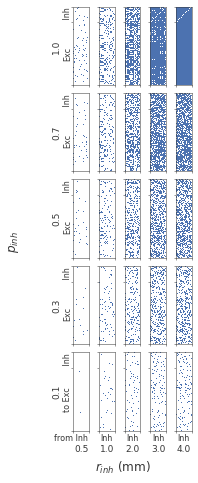

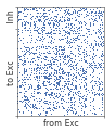

In [7]:
fig, axs = plt.subplots(5,5, figsize=pu.halfwidth(6), layout='compressed')
fig2, ax_exc = plt.subplots(figsize=(2,2))
plot_prototype(fig, axs, ax_exc)

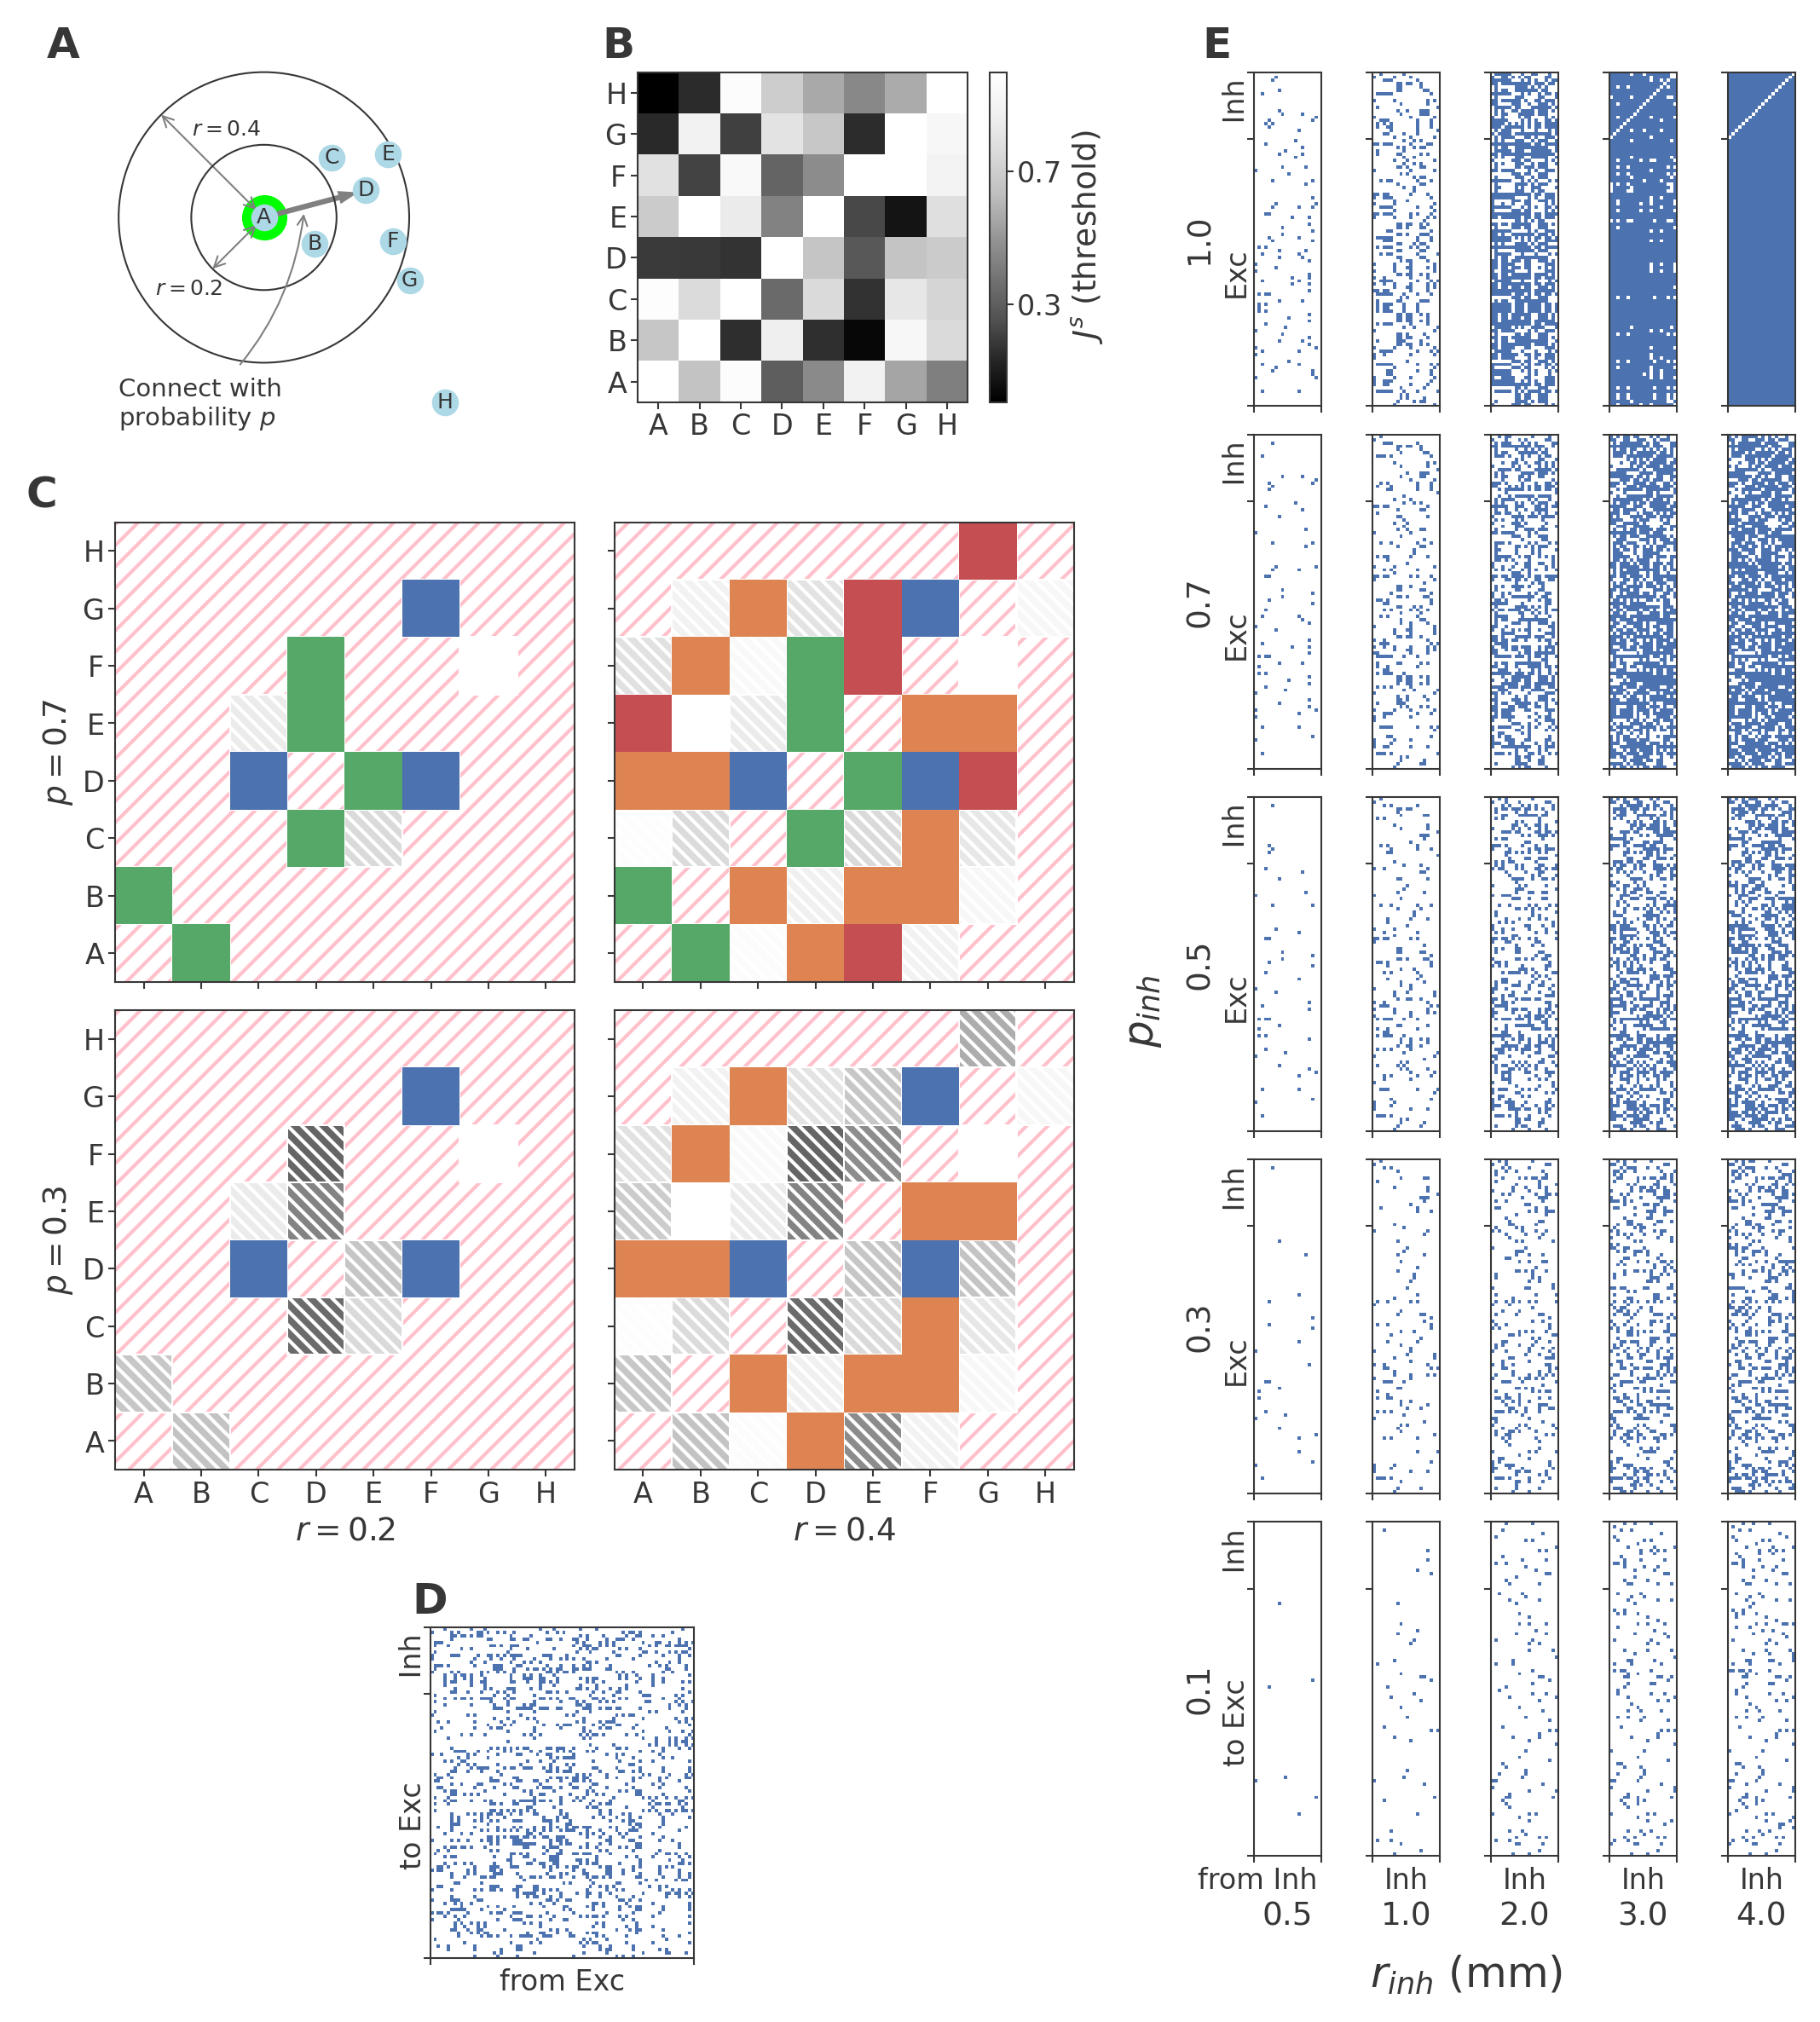

In [8]:
fig = plt.figure(figsize=pu.fullwidth(7), layout='compressed', facecolor='w', dpi=300)
fgs = fig.add_gridspec(3, 2, height_ratios=(1,2.5,1), width_ratios=(1.5,1))

ab = fig.add_subfigure(fgs[0,0])
axs = ab.subplots(1,2)
rs = (.2, .4)
ps = (.3, .7)
plot_space(axs[0], *rs)
plot_J(axs[1], *ps)
pu.label_panel(axs[0], 0)
pu.label_panel(axs[1], 1)

c = fig.add_subfigure(fgs[1,0])
axs = c.subplots(2,2, gridspec_kw=dict(wspace=0))
plot_M(axs, rs, ps)
pu.label_panel(axs[0,0], 2)

d = fig.add_subfigure(fgs[2,0])
ax_exc = d.subplots()
pu.label_panel(ax_exc, 3)

e = fig.add_subfigure(fgs[:,1])
axs = e.subplots(5,5)
pu.label_panel(axs[0,0], 4)

plot_prototype(e, axs, ax_exc)

fig.savefig('Figure 2.tif', bbox_inches='tight')